# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project we will segment neighborhoods in <b>Tel-Aviv</b> based on the average <b>closing hour</b> of recreational venues, with which I hope to help people and agencies make informed decisions.
We will use open-source data resources and data analysis tools for this project.
The potential stakeholders of such information include:
1. Families looking for a quiet neighborhood to live in
2. Young adults looking for a neighborhood with rich nightlife
3. An entrepreneur looking to open a late-night venue in an area with a large amount of such activity already

## Data <a name="data"></a>

Based on the goals of this project we will require an open data source with information about venues, including their type, location, and closing hours.
For this we will use the following sources:
1. Google Geocoding API to retrieve locations based on names
2. Foursquare API to retrieve all the venues and related information
3. Neighborhood polygons from the Tel-Aviv Municipality GIS website

### Includes

In [96]:
# First, some uncludes
import requests
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize 
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
from datetime import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
import fiona
import functools
import operator
import geopandas as gpd
from shapely.geometry import Point
from sklearn.cluster import KMeans

### Tel Aviv Neighborhoods


Download the neighborhood polygons shapefile from the Tel Aviv Municipality GIS website: https://gisn.tel-aviv.gov.il/
Open as GeoDataFrame (with the geometry column) and get the centroid from each for the Foursquare API search.

In [82]:
tlv_neighborhoods

shemshchun     ShapeArea  \
0                   אזור שדה דב  1.307955e+06   
1                     צוקי אביב  1.288925e+06   
2                   'רמת אביב ג  1.101582e+06   
3                אוניברסיטת ת"א  1.459851e+06   
4                    כוכב הצפון  4.212298e+05   
5            נוה אביבים וסביבתה  7.761160e+05   
6                      רמת-אביב  8.619284e+05   
7                  מרכז הירידים  4.007361e+05   
8                       נופי ים  8.679529e+05   
9                      'תכנית ל  9.167206e+05   
10                         בבלי  7.890963e+05   
11                    קרית שאול  3.543811e+05   
12                       המשתלה  2.888987e+05   
13          גני צהלה, רמות צהלה  4.710936e+05   
14                         צהלה  5.578905e+05   
15                      תל ברוך  7.037665e+05   
16                 'נאות אפקה ב  3.300835e+05   
17                       רביבים  3.806944e+05   
18                 'נאות אפקה א  3.536114e+05   
19                 תל ברוך צפון  2.401788e+05   
20                  נמל תל-אביב  2.121006e+05   
21     הצפון החדש - החלק הצפוני  7.145993e+05   
22     הצפון הישן - החלק הצפוני  1.819996e+06   
23                 צמרות איילון  5.493988e+05   
24  הצפון החדש-סביבת ככר המדינה  9.807822e+05   
25       הצפון הישן-החלק הדרומי  1.348333e+06   
26       הצפון החדש-החלק הדרומי  9.615801e+05   
27                   לב תל-אביב  1.977207e+06   
28                  כרם התימנים  3.913410e+05   
29                   מונטיפיורי  1.126143e+06   
..                          ...           ...   
41                  רמת הטייסים  3.271975e+05   
42                        אורות  2.772342e+05   
43                        התקוה  9.465344e+05   
44                       נוה חן  3.040615e+05   
45     נוה אליעזר וכפר שלם מזרח  3.307963e+05   
46      נוה ברבור, כפר שלם מערב  2.398694e+05   
47                         כפיר  2.533470e+05   
48                     ניר אביב  1.850193e+05   
49                עזרא והארגזים  4.526300e+05   
50                    פארק דרום  1.107966e+06   
51                  לבנה,ידידיה  3.835239e+05   
52                    רמת החייל  7.248385e+05   
53         (יפו ד' (גבעת התמרים  3.895917e+05   
54                       נוה דן  4.055767e+05   
55                     הדר-יוסף  7.154430e+05   
56                    מעוז אביב  3.107202e+05   
57                      נוה צדק  9.013887e+05   
58       אזור תעסוקה-צומת חולון  5.805777e+05   
59                     צפון יפו  8.385962e+05   
60       מכללת יפו תל אביב ודקר  6.751022e+05   
61                 פארק החורשות  2.756653e+05   
62                         אפקה  5.343914e+05   
63   גבעת הרצל, אזור המלאכה-יפו  6.194862e+05   
64                       עתידים  5.037697e+05   
65                      נוה שרת  4.002961e+05   
66                  פארק הירקון  3.750740e+06   
67                     נוה עופר  8.605188e+05   
68             יפו ג' ונוה גולן  4.464244e+05   
69             עג'מי וגבעת עליה  1.059984e+06   
70          צהלון ושיכוני חסכון  6.979523e+05   

                                             geometry  \
0   POLYGON ((34.78838878496115 32.12365553667512,...   
1   POLYGON ((34.79624294387394 32.13038781815963,...   
2   POLYGON ((34.80855445602733 32.12871199261001,...   
3   POLYGON ((34.80235417670993 32.11806158807154,...   
4   POLYGON ((34.78352246297847 32.09863630286622,...   
5   POLYGON ((34.79925354865136 32.11319615340876,...   
6   POLYGON ((34.80144744018857 32.11323862928469,...   
7   POLYGON ((34.81399322720033 32.10681882224932,...   
8   POLYGON ((34.79089507055232 32.11244495108061,...   
9   POLYGON ((34.7924674297965 32.11244718963559, ...   
10  POLYGON ((34.80290155005605 32.10007307118713,...   
11  POLYGON ((34.82658600520066 32.12848330350564,...   
12  POLYGON ((34.83579159615444 32.12769344206727,...   
13  POLYGON ((34.830821820846 32.11925231265563, 3...   
14  POLYGON ((34.83993340620034 32.12539141113352,...   
15  POLYGON ((34.81142131218427 32.12299758185947,...   
16  POLYGON (

In [84]:
# Check for NaN values
tlv_neighborhoods.isnull().values.any()

False

### Get Tel Aviv location and create map of neighborhoods

In [7]:
url = 'https://maps.googleapis.com/maps/api/geocode/json?address=תל אביב&key='+ googlekey
response = requests.get(url)
res_text = json.loads(response.text)
loc = res_text['results'][0]['geometry']['location']
latitude = loc['lat']
longitude = loc['lng']

telavivcoords = latitude, longitude
telavivcoords

(32.0852999, 34.78176759999999)

### Convert GeoDataFrame to GeoJSON for use in folium

In [8]:
tlv_neighborhoods.to_file('tlv_geo.geojson', driver='GeoJSON')

with open('tlv_geo.geojson') as f:
    tlv_geojson = json.load(f)
    
tlv_geojson

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {'shemshchun': 'אזור שדה דב', 'ShapeArea': 1307955.33559649},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[34.78838878496115, 32.12365553667512],
      [34.788383477895714, 32.12363642852407],
      [34.787991298953614, 32.12223231893461],
      [34.78742952285432, 32.12109903173299],
      [34.7873349786597, 32.12076637768932],
      [34.78720402857917, 32.12044012350072],
      [34.78688438976651, 32.11986486935012],
      [34.78495153798568, 32.116696707277626],
      [34.78478933085543, 32.11639649860668],
      [34.78461515710927, 32.11595844868535],
      [34.784516623751465, 32.115570076022955],
      [34.78446643449546, 32.11517592084045],
      [34.78439392282997, 32.11187929477825],
      [34.78371438043588, 32.109426705217956],
      [34.78239738056748, 32.104673026554636],
      [34.78202675371289, 32.10381146222918],
      [34.78202509749267, 32.103807615106376],
      [34.78142978

### Create map of Tel Aviv to display neighborhoods
Neighborhoods are displayed as a choropleth map, with their relative size as the variable (for testing and display purposes.)

In [9]:
map_tlv = folium.Map(location=telavivcoords, zoom_start=12)

map_tlv.choropleth(
 geo_data=tlv_geojson,
 name='Tel Aviv Neighborhoods',
 data=tlv_data,
 columns=['shemshchun', 'ShapeArea'],
 key_on='feature.properties.shemshchun',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Neighborhoods Area'
)
folium.LayerControl().add_to(map_tlv)

map_tlv

C:\Anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


### View the neighborhoods' centroids

In [11]:
# add markers to map
for index, neighborhood in tlv_neighborhoods.iterrows():
    label = '{}, {}'.format(neighborhood['shemshchun'], 'תל אביב - יפו')
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [neighborhood['Centroids'].y, neighborhood['Centroids'].x],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tlv)

map_tlv

## Foursquare
Set up the search query variables

In [88]:
LIMIT = 20000
radius = 2000
VERSION = int(dt.today().strftime('%Y%m%d'))
VERSION

20190903

In [14]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Foursquare Category Ids

* Arts and entertainment: 4d4b7104d754a06370d81259
* Food: 4d4b7105d754a06374d81259
* Nightlife Spot: 4d4b7105d754a06376d81259
* Outdoors & Recreation: 4d4b7105d754a06377d81259
* Professional & Other Places: 4d4b7105d754a06375d81259
* Shop & Service: 4d4b7105d754a06378d81259

In [17]:
categoryIds = '4d4b7104d754a06370d81259,4d4b7105d754a06374d81259,4d4b7105d754a06376d81259,4d4b7105d754a06377d81259,4d4b7105d754a06375d81259,4d4b7105d754a06378d81259'

### Search for the venues in each neighborhood
Set up dataframe with all the information

In [20]:
nearby_venues = pd.DataFrame(columns=['Name', 'id', 'Latitude', 'Longitude', 'Category'])
nearby_venues

Empty DataFrame
Columns: [Name, id, Latitude, Longitude, Category]
Index: []

In [21]:
for index, neighborhood in tlv_neighborhoods.iterrows():    
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&intent=browse&radius={}&limit={}'.format(
            FOURSQUARE_CLIENTID, 
            FOURSQUARE_CLIENTSECRET, 
            VERSION, 
            neighborhood[3].y, 
            neighborhood[3].x,
            categoryIds,
            radius, 
            LIMIT)
    results = requests.get(url).json()['response']['venues']
    venues = []
    for venue in results:
        if len(venue['categories']) > 0:
            venues.append((venue['name'], venue['id'], venue['location']['lat'], venue['location']['lng'],
                    venue['categories'][0]['name']))
        else:
            venues.append((venue['name'], venue['id'], venue['location']['lat'], venue['location']['lng'],
                    np.nan))
    
    venues_to_append = pd.DataFrame(venues, columns=['Name', 'id', 'Latitude', 'Longitude', 'Category'])
    
    nearby_venues = nearby_venues.append(venues_to_append, ignore_index=True)
    
nearby_venues
    

Name  \
0     TAU Sports Center (מרכז הספורט באוניברסיטת תל ...   
1                        Tel Baruch Beach (חוף תל ברוך)   
2                                          חניון רידינג   
3                                            Super Yuda   
4                      Ramat Aviv Mall (קניון רמת אביב)   
5               Eretz Israel Museum (מוזיאון ארץ ישראל)   
6                                Super Yuda (סופר יודה)   
7                                     Sporteck (ספורטק)   
8                                     Shalvata (שלוותה)   
9                              Hummus Asli (חומוס אסלי)   
10                                        דואר סניף למד   
11                                Beta Caffè (ביתא קפה)   
12                                      חוות צוק המסעדה   
13                                  Neve Avivim Country   
14                         HaYarkon Bridge / גשר הירקון   
15                                           Blue (בלו)   
16                            Yarkon River (נחל הירקון)   
17                        New Ramat Aviv (Playground 2)   
18                    מתחם האימונים בספורטק - הפועל ת'א   
19                                      מסעדת נאם - Nam   
20                                            el vecino   
21                                        Aroma (ארומה)   
22                                          Delek (דלק)   
23                                 גן כלבים פארק הירקון   
24                                       Arcaffe Bakery   
25                                       Kitchen Market   
26                           Sde Dov Beach (חוף שדה דב)   
27                               Max Brenner (מקס ברנר)   
28                         Hummus Ashkara (חומוס אשכרה)   
29                                             Playdate   
...                                                 ...   
3382                      Big Itzik Grill (איציק הגדול)   
3383                                         A la Rampa   
3384                                      Barby (בארבי)   
3385                                        Yaffo Beach   
3386                                   Ramesses (רעמסס)   
3387                                      Elifelet Park   
3388                                              Vista   
3389                                    Casino San Remo   
3390  Suspended Orange Tree / Подвешеное Апельсиново...   
3391      The Old Man & The Sea العجوز والبحر הזקן והים   
3392                    Sea Palace Beach (חוף סי פאלאס)   
3393                                      Super Bareket   
3394                                חינאווי בשר Hinnawi   
3395                                    מיני מרקט הכיכר   
3396                                       אונזה / Onza   
3397                                       Yaffa Knafeh   
3398                                          Akbar Bar   
3399                                      Beit Kandinof   
3400                               Cafe Alma (קפה עלמה)   
3401                                              Raisa   
3402          The Licensing Office / МРЭО / משרד הרישוי   
3403                                              Gemma   
3404         Ali Karawan Abu Hassan (עלי קרואן אבו חסן)   
3405                                           Art Club   
3406                              מרכז החומוס האסלי יפו   
3407                                 חצר גולדמן Goldman   
3408                                       Par Derriere   
3409                                             Cassis   
3410                               Abuelafia (אבולעפיה)   
3411                                 Rak Basar / רק בשר   

                            id   Latitude  Longitude  \
0     4be516bf7e2a76b01dc21c9b  32.115798  34.802301   
1     4bdadb15c79cc928cef87fe9  32.121031  34.782308   
2     4c75fe952db5236ae3b9be79  32.099068  34.779724   
3     59a0912e9b04732957d43d76  32.112197  34.787434   
4     4b1aaf4ff964a52055ef23e3  32.112136  34.795028   
5     4b0588e5f964a52089de22e3  32.103254  34.796234   


In [22]:
nearby_venues['Point'] = [Point(row.Longitude,row.Latitude) for idx, row in nearby_venues.iterrows()]
nearby_venues

Name  \
0     TAU Sports Center (מרכז הספורט באוניברסיטת תל ...   
1                        Tel Baruch Beach (חוף תל ברוך)   
2                                          חניון רידינג   
3                                            Super Yuda   
4                      Ramat Aviv Mall (קניון רמת אביב)   
5               Eretz Israel Museum (מוזיאון ארץ ישראל)   
6                                Super Yuda (סופר יודה)   
7                                     Sporteck (ספורטק)   
8                                     Shalvata (שלוותה)   
9                              Hummus Asli (חומוס אסלי)   
10                                        דואר סניף למד   
11                                Beta Caffè (ביתא קפה)   
12                                      חוות צוק המסעדה   
13                                  Neve Avivim Country   
14                         HaYarkon Bridge / גשר הירקון   
15                                           Blue (בלו)   
16                            Yarkon River (נחל הירקון)   
17                        New Ramat Aviv (Playground 2)   
18                    מתחם האימונים בספורטק - הפועל ת'א   
19                                      מסעדת נאם - Nam   
20                                            el vecino   
21                                        Aroma (ארומה)   
22                                          Delek (דלק)   
23                                 גן כלבים פארק הירקון   
24                                       Arcaffe Bakery   
25                                       Kitchen Market   
26                           Sde Dov Beach (חוף שדה דב)   
27                               Max Brenner (מקס ברנר)   
28                         Hummus Ashkara (חומוס אשכרה)   
29                                             Playdate   
...                                                 ...   
3382                      Big Itzik Grill (איציק הגדול)   
3383                                         A la Rampa   
3384                                      Barby (בארבי)   
3385                                        Yaffo Beach   
3386                                   Ramesses (רעמסס)   
3387                                      Elifelet Park   
3388                                              Vista   
3389                                    Casino San Remo   
3390  Suspended Orange Tree / Подвешеное Апельсиново...   
3391      The Old Man & The Sea العجوز والبحر הזקן והים   
3392                    Sea Palace Beach (חוף סי פאלאס)   
3393                                      Super Bareket   
3394                                חינאווי בשר Hinnawi   
3395                                    מיני מרקט הכיכר   
3396                                       אונזה / Onza   
3397                                       Yaffa Knafeh   
3398                                          Akbar Bar   
3399                                      Beit Kandinof   
3400                               Cafe Alma (קפה עלמה)   
3401                                              Raisa   
3402          The Licensing Office / МРЭО / משרד הרישוי   
3403                                              Gemma   
3404         Ali Karawan Abu Hassan (עלי קרואן אבו חסן)   
3405                                           Art Club   
3406                              מרכז החומוס האסלי יפו   
3407                                 חצר גולדמן Goldman   
3408                                       Par Derriere   
3409                                             Cassis   
3410                               Abuelafia (אבולעפיה)   
3411                                 Rak Basar / רק בשר   

                            id   Latitude  Longitude  \
0     4be516bf7e2a76b01dc21c9b  32.115798  34.802301   
1     4bdadb15c79cc928cef87fe9  32.121031  34.782308   
2     4c75fe952db5236ae3b9be79  32.099068  34.779724   
3     59a0912e9b04732957d43d76  32.112197  34.787434   
4     4b1aaf4ff964a52055ef23e3  32.112136  34.795028   
5     4b0588e5f964a52089de22e3  32.103254  34.796234   


In [23]:
nearby_venues = nearby_venues.drop_duplicates(subset=['id']).reset_index().drop('index', axis=1)
nearby_venues

Name  \
0    TAU Sports Center (מרכז הספורט באוניברסיטת תל ...   
1                       Tel Baruch Beach (חוף תל ברוך)   
2                                         חניון רידינג   
3                                           Super Yuda   
4                     Ramat Aviv Mall (קניון רמת אביב)   
5              Eretz Israel Museum (מוזיאון ארץ ישראל)   
6                               Super Yuda (סופר יודה)   
7                                    Sporteck (ספורטק)   
8                                    Shalvata (שלוותה)   
9                             Hummus Asli (חומוס אסלי)   
10                                       דואר סניף למד   
11                               Beta Caffè (ביתא קפה)   
12                                     חוות צוק המסעדה   
13                                 Neve Avivim Country   
14                        HaYarkon Bridge / גשר הירקון   
15                                          Blue (בלו)   
16                           Yarkon River (נחל הירקון)   
17                       New Ramat Aviv (Playground 2)   
18                   מתחם האימונים בספורטק - הפועל ת'א   
19                                     מסעדת נאם - Nam   
20                                           el vecino   
21                                       Aroma (ארומה)   
22                                         Delek (דלק)   
23                                גן כלבים פארק הירקון   
24                                      Arcaffe Bakery   
25                                      Kitchen Market   
26                          Sde Dov Beach (חוף שדה דב)   
27                              Max Brenner (מקס ברנר)   
28                        Hummus Ashkara (חומוס אשכרה)   
29                                            Playdate   
..                                                 ...   
638                                           Kodak IL   
639                            Super-Pharm (סופר-פארם)   
640                                        עמוס מזגנים   
641         Butchery de Bariloche (בוצ'רי דה ברילוצ'ה)   
642                                      אלוף המזרונים   
643                                Bnei Brak (בני ברק)   
644                                       הכל לבית אלי   
645                                 חצר גולדמן Goldman   
646                                       Par Derriere   
647                          Bat Yam Beach (חוף בת ים)   
648                                           Japanika   
649                                      Aroma (ארומה)   
650                                    Bat Yam (בת ים)   
651                                            Gorilla   
652                                         Villa Mare   
653                                          Café Café   
654                                       מאפיית הגבול   
655                                       דואר תל כביר   
656               Haj K'chil Skewers (שיפודי חג׳ כחיל)   
657     Wolfson Football Field / מתחם האימונים חודורוב   
658                       קופת חולים מכבי - סניף בת ים   
659                        Mediterranean Sea / Bat-Yam   
660                               Abuelafia (אבולעפיה)   
661                                 Rak Basar / רק בשר   
662   The Italian at The Flea Market (איטלקיה בפשפשים)   
663                         Dr. Shakshuka (ד"ר שקשוקה)   
664                                         The Chapel   
665                                             Urbano   
666                              St. George Restaurant   
667                                Hamalabiya (המלביה)   

                           id   Latitude  Longitude  \
0    4be516bf7e2a76b01dc21c9b  32.115798  34.802301   
1    4bdadb15c79cc928cef87fe9  32.121031  34.782308   
2    4c75fe952db5236ae3b9be79  32.099068  34.779724   
3    59a0912e9b04732957d43d76  32.112197  34.787434   
4    4b1aaf4ff964a52055ef23e3  32.112136  34.795028   
5    4b0588e5f964a52089de22e3  32.103254  34.796234   
6    524fa80193cd62672e5d17e8  32.095039  34.778606   
7    4bb1fc69

In [89]:
tlv_neighborhoods.crs = {'init' :'epsg:4326'}

In [25]:
nearby_venues_geo = gpd.GeoDataFrame(
    nearby_venues, geometry=nearby_venues['Point'])
nearby_venues_geo.crs = {'init' :'epsg:4326'}
nearby_venues_geo

Name  \
0    TAU Sports Center (מרכז הספורט באוניברסיטת תל ...   
1                       Tel Baruch Beach (חוף תל ברוך)   
2                                         חניון רידינג   
3                                           Super Yuda   
4                     Ramat Aviv Mall (קניון רמת אביב)   
5              Eretz Israel Museum (מוזיאון ארץ ישראל)   
6                               Super Yuda (סופר יודה)   
7                                    Sporteck (ספורטק)   
8                                    Shalvata (שלוותה)   
9                             Hummus Asli (חומוס אסלי)   
10                                       דואר סניף למד   
11                               Beta Caffè (ביתא קפה)   
12                                     חוות צוק המסעדה   
13                                 Neve Avivim Country   
14                        HaYarkon Bridge / גשר הירקון   
15                                          Blue (בלו)   
16                           Yarkon River (נחל הירקון)   
17                       New Ramat Aviv (Playground 2)   
18                   מתחם האימונים בספורטק - הפועל ת'א   
19                                     מסעדת נאם - Nam   
20                                           el vecino   
21                                       Aroma (ארומה)   
22                                         Delek (דלק)   
23                                גן כלבים פארק הירקון   
24                                      Arcaffe Bakery   
25                                      Kitchen Market   
26                          Sde Dov Beach (חוף שדה דב)   
27                              Max Brenner (מקס ברנר)   
28                        Hummus Ashkara (חומוס אשכרה)   
29                                            Playdate   
..                                                 ...   
638                                           Kodak IL   
639                            Super-Pharm (סופר-פארם)   
640                                        עמוס מזגנים   
641         Butchery de Bariloche (בוצ'רי דה ברילוצ'ה)   
642                                      אלוף המזרונים   
643                                Bnei Brak (בני ברק)   
644                                       הכל לבית אלי   
645                                 חצר גולדמן Goldman   
646                                       Par Derriere   
647                          Bat Yam Beach (חוף בת ים)   
648                                           Japanika   
649                                      Aroma (ארומה)   
650                                    Bat Yam (בת ים)   
651                                            Gorilla   
652                                         Villa Mare   
653                                          Café Café   
654                                       מאפיית הגבול   
655                                       דואר תל כביר   
656               Haj K'chil Skewers (שיפודי חג׳ כחיל)   
657     Wolfson Football Field / מתחם האימונים חודורוב   
658                       קופת חולים מכבי - סניף בת ים   
659                        Mediterranean Sea / Bat-Yam   
660                               Abuelafia (אבולעפיה)   
661                                 Rak Basar / רק בשר   
662   The Italian at The Flea Market (איטלקיה בפשפשים)   
663                         Dr. Shakshuka (ד"ר שקשוקה)   
664                                         The Chapel   
665                                             Urbano   
666                              St. George Restaurant   
667                                Hamalabiya (המלביה)   

                           id   Latitude  Longitude  \
0    4be516bf7e2a76b01dc21c9b  32.115798  34.802301   
1    4bdadb15c79cc928cef87fe9  32.121031  34.782308   
2    4c75fe952db5236ae3b9be79  32.099068  34.779724   
3    59a0912e9b04732957d43d76  32.112197  34.787434   
4    4b1aaf4ff964a52055ef23e3  32.112136  34.795028   
5    4b0588e5f964a52089de22e3  32.103254  34.796234   
6    524fa80193cd62672e5d17e8  32.095039  34.778606   
7    4bb1fc69

#### Use GeoPandas sjoin() to assign each venue to each neighborhood, by polygon

In [26]:
nearby_venues_in_neighborhoods = gpd.sjoin(nearby_venues_geo, tlv_neighborhoods)[['Name', 'id', 'Latitude', 'Longitude', 'Category', 'geometry', 'shemshchun']]
nearby_venues_in_neighborhoods = nearby_venues_in_neighborhoods.reset_index().drop('index', axis=1)
nearby_venues_in_neighborhoods

Name  \
0    TAU Sports Center (מרכז הספורט באוניברסיטת תל ...   
1              Eretz Israel Museum (מוזיאון ארץ ישראל)   
2                                         טניס תל אביב   
3                                   חניון רפואת שיניים   
4             The Steinhardt Museum Of Natural History   
5                                        Aroma (ארומה)   
6                                       Beit Hatfutsot   
7                                   Japanika (ג׳פניקה)   
8                        Hahoog Hatzfoni (החוג הצפוני)   
9                                       Oxygen Pilates   
10                                Yitzhak Rabin Center   
11                                      Palmach Museum   
12                                       Aroma (ארומה)   
13                      Tel Baruch Beach (חוף תל ברוך)   
14                                          Blue (בלו)   
15                          Sde Dov Beach (חוף שדה דב)   
16                                        חניון רידינג   
17                                   Sporteck (ספורטק)   
18                           Yarkon River (נחל הירקון)   
19                   מתחם האימונים בספורטק - הפועל ת'א   
20            Olympus climbing wall (קיר טיפוס ספורטק)   
21            Park HaYarkon (גני יהושוע / פארק הירקון)   
22                                              Yellow   
23                                   האגם בפארק הירקון   
24                                              Arnold   
25                                        גבעת המופעים   
26                                           שבע טחנות   
27                                           בבילה קפה   
28           Ganei Ha-Taaruha Bridge / גשר גני התערוכה   
29                                        גשר מבצע קדש   
..                                                 ...   
477                                            יוחננוף   
478                                        פינת השלושה   
479                                פארק יפו Jaffa Park   
480      The Old Man & The Sea العجوز والبحر הזקן והים   
481                                חינאווי בשר Hinnawi   
482         Ali Karawan Abu Hassan (עלי קרואן אבו חסן)   
483                                             Cassis   
484                         The Peres Center For Peace   
485                                  Mediterranean Sea   
486                              מקור הדגים-בטשון חמיס   
487        סופר חצות וחצי 24 שעות Hatzot Vahetzi Jaffa   
488                                        Babai באבאי   
489                                       פארק וולפסון   
490                         כספומט בנק הפועלים נווה חן   
491           Menahem Begin - Darom (מנחם בגין - דרום)   
492                                               פארק   
493                                     Yellow הטייסים   
494                                        האופה מבגדד   
495                            מרפאת גבעתיים לחיות בית   
496                                         סלון חללית   
497                                   Lightning's Roof   
498  Cable Waterskiing / Троссовые Водные Лыжи / סק...   
499                                         עיסא הדייג   
500                                      סופר פארם יפו   
501                                      פז דרך בן צבי   
502                                          Samarkand   
503                                       דואר תל כביר   
504     Wolfson Football Field / מתחם האימונים חודורוב   
505                              ביהס לטבע סביבה וחברה   
506                                       מאפיית הגבול   

                           id   Latitude  Longitude  \
0    4be516bf7e2a76b01dc21c9b  32.115798  34.802301   
1    4b0588e5f964a52089de22e3  32.103254  34.796234   
2    4f27cbbd4fc661e0e7bd8694  32.100981  34.796727   
3    4f8fb64be4b060f54c5eb810  32.116879  34.804178   
4    58d96885da54ae60aab063be  32.113802  34.807583   
5    4be13f3240d676b075db04ee  32.113779  34.804979   
6    4bc6c9c8bf29c9b6ad53fa2a  32.113758  34.805006   
7    5725d44e

In [27]:
# Check for NaN values
nearby_venues_in_neighborhoods.isnull().values.any()

False

#### Solve some issues folium apparently has with Hebrew

In [30]:
nearby_venues_in_neighborhoods['Name'] = nearby_venues_in_neighborhoods['Name'].apply(lambda x: x.replace("'","\'"))
nearby_venues_in_neighborhoods['Name'] = nearby_venues_in_neighborhoods['Name'].apply(lambda x: x.replace('"','\"'))
nearby_venues_in_neighborhoods

Name  \
0    TAU Sports Center (מרכז הספורט באוניברסיטת תל ...   
1              Eretz Israel Museum (מוזיאון ארץ ישראל)   
2                                         טניס תל אביב   
3                                   חניון רפואת שיניים   
4             The Steinhardt Museum Of Natural History   
5                                        Aroma (ארומה)   
6                                       Beit Hatfutsot   
7                                   Japanika (ג׳פניקה)   
8                        Hahoog Hatzfoni (החוג הצפוני)   
9                                       Oxygen Pilates   
10                                Yitzhak Rabin Center   
11                                      Palmach Museum   
12                                       Aroma (ארומה)   
13                      Tel Baruch Beach (חוף תל ברוך)   
14                                          Blue (בלו)   
15                          Sde Dov Beach (חוף שדה דב)   
16                                        חניון רידינג   
17                                   Sporteck (ספורטק)   
18                           Yarkon River (נחל הירקון)   
19                   מתחם האימונים בספורטק - הפועל ת'א   
20            Olympus climbing wall (קיר טיפוס ספורטק)   
21            Park HaYarkon (גני יהושוע / פארק הירקון)   
22                                              Yellow   
23                                   האגם בפארק הירקון   
24                                              Arnold   
25                                        גבעת המופעים   
26                                           שבע טחנות   
27                                           בבילה קפה   
28           Ganei Ha-Taaruha Bridge / גשר גני התערוכה   
29                                        גשר מבצע קדש   
..                                                 ...   
477                                            יוחננוף   
478                                        פינת השלושה   
479                                פארק יפו Jaffa Park   
480      The Old Man & The Sea العجوز والبحر הזקן והים   
481                                חינאווי בשר Hinnawi   
482         Ali Karawan Abu Hassan (עלי קרואן אבו חסן)   
483                                             Cassis   
484                         The Peres Center For Peace   
485                                  Mediterranean Sea   
486                              מקור הדגים-בטשון חמיס   
487        סופר חצות וחצי 24 שעות Hatzot Vahetzi Jaffa   
488                                        Babai באבאי   
489                                       פארק וולפסון   
490                         כספומט בנק הפועלים נווה חן   
491           Menahem Begin - Darom (מנחם בגין - דרום)   
492                                               פארק   
493                                     Yellow הטייסים   
494                                        האופה מבגדד   
495                            מרפאת גבעתיים לחיות בית   
496                                         סלון חללית   
497                                   Lightning's Roof   
498  Cable Waterskiing / Троссовые Водные Лыжи / סק...   
499                                         עיסא הדייג   
500                                      סופר פארם יפו   
501                                      פז דרך בן צבי   
502                                          Samarkand   
503                                       דואר תל כביר   
504     Wolfson Football Field / מתחם האימונים חודורוב   
505                              ביהס לטבע סביבה וחברה   
506                                       מאפיית הגבול   

                           id   Latitude  Longitude  \
0    4be516bf7e2a76b01dc21c9b  32.115798  34.802301   
1    4b0588e5f964a52089de22e3  32.103254  34.796234   
2    4f27cbbd4fc661e0e7bd8694  32.100981  34.796727   
3    4f8fb64be4b060f54c5eb810  32.116879  34.804178   
4    58d96885da54ae60aab063be  32.113802  34.807583   
5    4be13f3240d676b075db04ee  32.113779  34.804979   
6    4bc6c9c8bf29c9b6ad53fa2a  32.113758  34.805006   
7    5725d44e

### Create a unique color for each category type in the folium map and set it up

In [32]:
types_of_venues = nearby_venues_in_neighborhoods['Category'].value_counts()
types_of_venues

Café                             50
Bakery                           21
Beach                            20
Park                             17
Restaurant                       16
Middle Eastern Restaurant        15
Grocery Store                    13
Seafood Restaurant               12
Mediterranean Restaurant         12
Bar                              11
Coffee Shop                      10
Italian Restaurant               10
Gas Station                      10
Shopping Mall                     9
Building                          9
Office                            8
Pool                              7
Asian Restaurant                  7
Bridge                            7
Gym                               7
Other Great Outdoors              6
Parking                           6
Supermarket                       6
Plaza                             5
Bistro                            5
Garden                            5
Israeli Restaurant                5
Post Office                 

In [33]:
types_of_venues_count = len(types_of_venues)
types_of_venues_count

136

In [34]:
sns_colors = sns.color_palette("hls", types_of_venues_count)
sns_colors

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.3941411764705882, 0.33999999999999997),
 (0.86, 0.41708235294117646, 0.33999999999999997),
 (0.86, 0.4400235294117647, 0.33999999999999997),
 (0.86, 0.46296470588235294, 0.33999999999999997),
 (0.86, 0.4859058823529412, 0.33999999999999997),
 (0.86, 0.5088470588235294, 0.33999999999999997),
 (0.86, 0.5317882352941177, 0.33999999999999997),
 (0.86, 0.5547294117647059, 0.33999999999999997),
 (0.86, 0.5776705882352942, 0.33999999999999997),
 (0.86, 0.6006117647058823, 0.33999999999999997),
 (0.86, 0.6235529411764705, 0.33999999999999997),
 (0.86, 0.6464941176470588, 0.33999999999999997),
 (0.86, 0.669435294117647, 0.33999999999999997),
 (0.86, 0.6923764705882353, 0.33999999999999997),
 (0.86, 0.7153176470588235, 0.33999999999999997),
 (0.86, 0.7382588235294117, 0.33999999999999997),
 (0.86, 0.7612000000000001, 0.33999999999999997),
 (0.86, 0.7841411764705882, 0.33999999999999997),
 (0.86, 0.8070823529411765, 0.33999999999999997),
 (0.86, 0.8

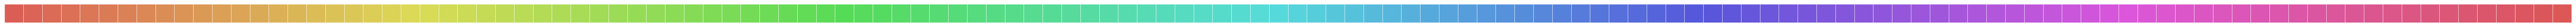

In [35]:
pallete = sns.palplot(sns_colors)
pallete

In [36]:
venue_colors = pd.DataFrame({'types_of_venues': types_of_venues, 'venue_type_color': sns_colors})
venue_colors

types_of_venues  \
Café                                        50   
Bakery                                      21   
Beach                                       20   
Park                                        17   
Restaurant                                  16   
Middle Eastern Restaurant                   15   
Grocery Store                               13   
Seafood Restaurant                          12   
Mediterranean Restaurant                    12   
Bar                                         11   
Coffee Shop                                 10   
Italian Restaurant                          10   
Gas Station                                 10   
Shopping Mall                                9   
Building                                     9   
Office                                       8   
Pool                                         7   
Asian Restaurant                             7   
Bridge                                       7   
Gym                                          7   
Other Great Outdoors                         6   
Parking                                      6   
Supermarket                                  6   
Plaza                                        5   
Bistro                                       5   
Garden                                       5   
Israeli Restaurant                           5   
Post Office                                  5   
Tech Startup                                 5   
Hotel                                        5   
...                                        ...   
Hardware Store                               1   
Miscellaneous Shop                           1   
City                                         1   
Outdoor Event Space                          1   
Rock Climbing Spot                           1   
Town                                         1   
Gym / Fitness Center                         1   
Veterinarian                                 1   
Harbor / Marina                              1   
Car Wash                                     1   
Argentinian Restaurant                       1   
Basketball Court                             1   
College Gym                                  1   
BBQ Joint                                    1   
Tapas Restaurant                             1   
Baseball Stadium                             1   
Japanese Restaurant                          1   
Toy / Game Store                             1   
Church                                       1   
Swim School                                  1   
Dentist's Office                             1   
American Restaurant                          1   
Irish Pub                                    1   
Vegetarian / Vegan Restaurant                1   
River                                        1   
Animal Shelter                               1   
Wine Shop                                    1   
Business Center                              1   
Track Stadium                                1   
Theme Park                                   1   

                                                               venue_type_color  
Café                                        (0.86, 0.3712, 0.33999999999999997)  
Bakery                          (0.86, 0.3941411764705882, 0.33999999999999997)  
Beach                          (0.86, 0.41708235294117646, 0.33999999999999997)  
Park                            (0.86, 0.4400235294117647, 0.33999999999999997)  
Restaurant                     (0.86, 0.46296470588235294, 0.33999999999999997)  
Middle Eastern Restaurant       (0.86, 0.4859058823529412, 0.33999999999999997)  
Grocery Store                   (0.86, 0.5088470588235294, 0.33999999999999997)  
Seafood Restaurant              (0.86, 0.5317882352941177, 0.33999999999999997)  
Mediterranean Restaurant        (0.86, 0.5547294117647059, 0.33999999999999997)  
Bar                             (0.86, 0.5776705882352942, 0.33999999999999997)  
Coffee Shop                 

In [37]:
def rgb_to_html(rgb):
    r, g, b = rgb
    rgb = (int(255*r), int(255*g), int(255*b))
    return '#%02x%02x%02x' % rgb

In [38]:
venue_colors['venue_type_color'] = venue_colors['venue_type_color'].apply(lambda x: rgb_to_html(x))
venue_colors

types_of_venues venue_type_color
Café                                        50          #db5e56
Bakery                                      21          #db6456
Beach                                       20          #db6a56
Park                                        17          #db7056
Restaurant                                  16          #db7656
Middle Eastern Restaurant                   15          #db7b56
Grocery Store                               13          #db8156
Seafood Restaurant                          12          #db8756
Mediterranean Restaurant                    12          #db8d56
Bar                                         11          #db9356
Coffee Shop                                 10          #db9956
Italian Restaurant                          10          #db9f56
Gas Station                                 10          #dba456
Shopping Mall                                9          #dbaa56
Building                                     9          #dbb056
Office                                       8          #dbb656
Pool                                         7          #dbbc56
Asian Restaurant                             7          #dbc256
Bridge                                       7          #dbc756
Gym                                          7          #dbcd56
Other Great Outdoors                         6          #dbd356
Parking                                      6          #dbd956
Supermarket                                  6          #d7db56
Plaza                                        5          #d1db56
Bistro                                       5          #cbdb56
Garden                                       5          #c5db56
Israeli Restaurant                           5          #bfdb56
Post Office                                  5          #b9db56
Tech Startup                                 5          #b4db56
Hotel                                        5          #aedb56
...                                        ...              ...
Hardware Store                               1          #b856db
Miscellaneous Shop                           1          #be56db
City                                         1          #c456db
Outdoor Event Space                          1          #c956db
Rock Climbing Spot                           1          #cf56db
Town                                         1          #d556db
Gym / Fitness Center                         1          #db56db
Veterinarian                                 1          #db56d5
Harbor / Marina                              1          #db56cf
Car Wash                                     1          #db56c9
Argentinian Restaurant                       1          #db56c3
Basketball Court                             1          #db56bd
College Gym                                  1          #db56b8
BBQ Joint                                    1          #db56b2
Tapas Restaurant                             1          #db56ac
Baseball Stadium                             1          #db56a6
Japanese Restaurant                          1          #db56a0
Toy / Game Store                             1          #db569a
Church                                       1          #db5694
Swim School                                  1          #db568f
Dentist's Office                             1          #db5689
American Restaurant                          1          #db5683
Irish Pub                                    1          #db567d
Vegetarian / Vegan Restaurant                1          #db5677
River                                        1          #db5671
Animal Shelter                               1          #db566b
Wine Shop                                    1          #db5666
Business Center                              1          #db5660
Track Stadium                                1          #db565a
Theme Park                                   1          #db5856

[136 rows x 2 columns]

In [39]:
def get_color_from_venue(cat):
    try:
        color = venue_colors.loc[cat]['venue_type_color']
        return color
    except:
        return 'black'

In [68]:
map_tlv_venues = folium.Map(location=telavivcoords, zoom_start=12)

for index, neighborhood in tlv_neighborhoods.iterrows():
    label = '{}'.format(neighborhood['shemshchun'])
    label = folium.Popup(label, parse_html=True)
    poly = folium.GeoJson(neighborhood['geometry'],
                          style_function=lambda feature: {
                                'fillColor': 'yellow',
                                'color': 'black',
                                'weight': 1,
                                'fill_opacity': 0.05
                            }
             )
    label.add_to(poly)
    poly.add_to(map_tlv_venues)
    
map_tlv_venues

### All the venues (507 in total) we had retrieved from Foursquare

In [69]:
for idx, venue in nearby_venues_in_neighborhoods.iterrows():
    label = '{}: {}, {}'.format(venue['Name'], venue['Category'], venue['shemshchun'])
    label = folium.Popup(label) 
    folium.CircleMarker(
        [venue['Latitude'], venue['Longitude']],
        radius=2,
        popup=label,
        color=get_color_from_venue(venue['Category']),
        fill=True,
        fill_color=get_color_from_venue(venue['Category']),
        fill_opacity=0.7,
        parse_html=False).add_to(map_tlv_venues)  


map_tlv_venues

### Get average closing hour for each neighborhood
Using Foursquare Venue Hours API call

A Venue Hours query Example:

In [94]:
url = 'https://api.foursquare.com/v2/venues/4be516bf7e2a76b01dc21c9b/hours?client_id={}&client_secret={}&v={}'.format(
        FOURSQUARE_CLIENTID, 
        FOURSQUARE_CLIENTSECRET, 
        VERSION)
results = requests.get(url).json()

results

{'meta': {'code': 200, 'requestId': '5d6ea657a87921002cbbac43'},
 'response': {'hours': {'timeframes': [{'days': [1, 2, 3, 4],
     'includesToday': True,
     'open': [{'start': '0515', 'end': '2200'}],
     'segments': []},
    {'days': [5], 'open': [{'start': '0515', 'end': '+0000'}], 'segments': []},
    {'days': [6],
     'open': [{'start': '0645', 'end': '2000'}],
     'segments': []}]},
  'popular': {'timeframes': [{'days': [2],
     'includesToday': True,
     'open': [{'start': '1000', 'end': '2300'}],
     'segments': []},
    {'days': [3],
     'open': [{'start': '0800', 'end': '1300'},
      {'start': '1600', 'end': '2100'}],
     'segments': []},
    {'days': [4], 'open': [{'start': '1400', 'end': '2200'}], 'segments': []},
    {'days': [5],
     'open': [{'start': '0700', 'end': '0800'},
      {'start': '1000', 'end': '2000'}],
     'segments': []},
    {'days': [6], 'open': [{'start': '0900', 'end': '2000'}], 'segments': []},
    {'days': [7], 'open': [{'start': '1300', 

In [47]:
def get_average_closing_hour(venue_id):
    url = 'https://api.foursquare.com/v2/venues/' + venue_id + '/hours?client_id={}&client_secret={}&v={}'.format(
            FOURSQUARE_CLIENTID, 
            FOURSQUARE_CLIENTSECRET, 
            VERSION)
    results = requests.get(url).json()
    
    tot_time = 0
    weights = 0
    ishours = False
    ispopular = False
    
    try:
        for day in results['response']['hours']['timeframes']:
            ishours = True
            for x in day:
                if x=='open':
                    try:
                        last_open = day[x][int(len(day[x])-1)]
                        weight = len(day['days'])
                        weights += len(day['days'])
                        for soe in last_open:
                            if soe=='end':
                                mytime = last_open[soe].replace('+', '')
                                time = mytime.replace('0000', '2400')
                                hours = time[:2]
                                minutes = time[2:]
                                tot_time += ((int(hours) + int(minutes)/60))*weight
                    except:
                        ishours = False

        avg_hour = tot_time / weights
        avg_hours = int(avg_hour)
        avg_minutes = int((avg_hour-avg_hours)*60)
        avg_hour = str(avg_hours) + ':' + str(avg_minutes)
        avg_hour = pd.to_datetime(avg_hour, format='%H:%M')
    except:
        ishours = False
    
    try:
        for day in results['response']['popular']['timeframes']:
            ispopular = True
            for x in day:
                if x=='open':
                    try:
                        last_open = day[x][int(len(day[x])-1)]
                        weight = len(day['days'])
                        weights += len(day['days'])
                        for soe in last_open:
                            if soe=='end':
                                mytime = last_open[soe].replace('+', '')
                                time = mytime.replace('0000', '2400')
                                hours = time[:2]
                                minutes = time[2:]
                                tot_time += ((int(hours) + int(minutes)/60))*weight
                    except:
                        ispopular = False

        avg_hour = tot_time / weights
        avg_hours = int(avg_hour)
        avg_minutes = int((avg_hour-avg_hours)*60)
        avg_hour = str(avg_hours) + ':' + str(avg_minutes)
        avg_hour = pd.to_datetime(avg_hour, format='%H:%M')
    except:
        ispopular = False
    
    if ishours or ispopular:
            print(avg_hour)
            return avg_hour
    else:
        return np.nan

In [92]:
# Testing it out
get_average_closing_hour('4be516bf7e2a76b01dc21c9b')

1900-01-01 21:46:00


Timestamp('1900-01-01 21:46:00')

In [49]:
nearby_venues_in_neighborhoods['avg_closing_hour'] = nearby_venues_in_neighborhoods['id'].apply(lambda x: get_average_closing_hour(x))
nearby_venues_in_neighborhoods

1900-01-01 21:46:00
1900-01-01 21:34:00
1900-01-01 16:40:00
1900-01-01 17:45:00
1900-01-01 16:42:00
1900-01-01 18:30:00
1900-01-01 16:49:00
1900-01-01 20:51:00
1900-01-01 22:00:00
1900-01-01 21:25:00
1900-01-01 22:25:00
1900-01-01 15:00:00
1900-01-01 16:42:00
1900-01-01 19:51:00
1900-01-01 20:08:00
1900-01-01 17:00:00
1900-01-01 19:17:00
1900-01-01 20:17:00
1900-01-01 21:17:00
1900-01-01 21:04:00
1900-01-01 21:04:00
1900-01-01 19:00:00
1900-01-01 23:42:00
1900-01-01 09:08:00
1900-01-01 12:08:00
1900-01-01 22:47:00
1900-01-01 14:51:00
1900-01-01 23:08:00
1900-01-01 21:51:00
1900-01-01 23:42:00
1900-01-01 17:42:00
1900-01-01 20:17:00
1900-01-01 20:42:00
1900-01-01 22:30:00
1900-01-01 22:04:00
1900-01-01 23:00:00
1900-01-01 03:34:00
1900-01-01 21:19:00
1900-01-01 12:12:00
1900-01-01 15:00:00
1900-01-01 15:51:00
1900-01-01 18:42:00
1900-01-01 19:25:00
1900-01-01 05:51:00
1900-01-01 20:51:00
1900-01-01 23:25:00
1900-01-01 09:15:00
1900-01-01 08:55:00
1900-01-01 19:00:00
1900-01-01 18:17:00


Name  \
0    TAU Sports Center (מרכז הספורט באוניברסיטת תל ...   
1              Eretz Israel Museum (מוזיאון ארץ ישראל)   
2                                         טניס תל אביב   
3                                   חניון רפואת שיניים   
4             The Steinhardt Museum Of Natural History   
5                                        Aroma (ארומה)   
6                                       Beit Hatfutsot   
7                                   Japanika (ג׳פניקה)   
8                        Hahoog Hatzfoni (החוג הצפוני)   
9                                       Oxygen Pilates   
10                                Yitzhak Rabin Center   
11                                      Palmach Museum   
12                                       Aroma (ארומה)   
13                      Tel Baruch Beach (חוף תל ברוך)   
14                                          Blue (בלו)   
15                          Sde Dov Beach (חוף שדה דב)   
16                                        חניון רידינג   
17                                   Sporteck (ספורטק)   
18                           Yarkon River (נחל הירקון)   
19                   מתחם האימונים בספורטק - הפועל ת'א   
20            Olympus climbing wall (קיר טיפוס ספורטק)   
21            Park HaYarkon (גני יהושוע / פארק הירקון)   
22                                              Yellow   
23                                   האגם בפארק הירקון   
24                                              Arnold   
25                                        גבעת המופעים   
26                                           שבע טחנות   
27                                           בבילה קפה   
28           Ganei Ha-Taaruha Bridge / גשר גני התערוכה   
29                                        גשר מבצע קדש   
..                                                 ...   
477                                            יוחננוף   
478                                        פינת השלושה   
479                                פארק יפו Jaffa Park   
480      The Old Man & The Sea العجوز والبحر הזקן והים   
481                                חינאווי בשר Hinnawi   
482         Ali Karawan Abu Hassan (עלי קרואן אבו חסן)   
483                                             Cassis   
484                         The Peres Center For Peace   
485                                  Mediterranean Sea   
486                              מקור הדגים-בטשון חמיס   
487        סופר חצות וחצי 24 שעות Hatzot Vahetzi Jaffa   
488                                        Babai באבאי   
489                                       פארק וולפסון   
490                         כספומט בנק הפועלים נווה חן   
491           Menahem Begin - Darom (מנחם בגין - דרום)   
492                                               פארק   
493                                     Yellow הטייסים   
494                                        האופה מבגדד   
495                            מרפאת גבעתיים לחיות בית   
496                                         סלון חללית   
497                                   Lightning's Roof   
498  Cable Waterskiing / Троссовые Водные Лыжи / סק...   
499                                         עיסא הדייג   
500                                      סופר פארם יפו   
501                                      פז דרך בן צבי   
502                                          Samarkand   
503                                       דואר תל כביר   
504     Wolfson Football Field / מתחם האימונים חודורוב   
505                              ביהס לטבע סביבה וחברה   
506                                       מאפיית הגבול   

                           id   Latitude  Longitude  \
0    4be516bf7e2a76b01dc21c9b  32.115798  34.802301   
1    4b0588e5f964a52089de22e3  32.103254  34.796234   
2    4f27cbbd4fc661e0e7bd8694  32.100981  34.796727   
3    4f8fb64be4b060f54c5eb810  32.116879  34.804178   
4    58d96885da54ae60aab063be  32.113802  34.807583   
5    4be13f3240d676b075db04ee  32.113779  34.804979   
6    4bc6c9c8bf29c9b6ad53fa2a  32.113758  34.805006   
7    5725d44e

In [52]:
venues_not_null = nearby_venues_in_neighborhoods[pd.notnull(nearby_venues_in_neighborhoods['avg_closing_hour'])]
venues_not_null

Name  \
0    TAU Sports Center (מרכז הספורט באוניברסיטת תל ...   
1              Eretz Israel Museum (מוזיאון ארץ ישראל)   
4             The Steinhardt Museum Of Natural History   
5                                        Aroma (ארומה)   
6                                       Beit Hatfutsot   
10                                Yitzhak Rabin Center   
11                                      Palmach Museum   
14                                          Blue (בלו)   
16                                        חניון רידינג   
17                                   Sporteck (ספורטק)   
21            Park HaYarkon (גני יהושוע / פארק הירקון)   
22                                              Yellow   
24                                              Arnold   
25                                        גבעת המופעים   
26                                           שבע טחנות   
27                                           בבילה קפה   
33                                           קאנטרי ל׳   
37                    Ramat Aviv Mall (קניון רמת אביב)   
38                               Beta Caffè (ביתא קפה)   
40                                             Arcaffé   
41                            The Grand Cafe by Turkiz   
44                                     Maccabi Natural   
45                              Super Yuda (סופר יודה)   
46                            Hummus Asli (חומוס אסלי)   
47                                     מסעדת נאם - Nam   
49                        Hummus Ashkara (חומוס אשכרה)   
50                                        דרגסטור FOOD   
51                                   Shchupak (שצ'ופק)   
52                             Goof Rishon (גוף ראשון)   
54                                        Shila (שילה)   
..                                                 ...   
418                         Dr. Shakshuka (ד"ר שקשוקה)   
419                                             Urbano   
421                  The Old Man & The Sea (הזקן והים)   
423                   St. Peter's Church and Monastery   
424            The Jaffa Clock Tower (מגדל השעון ביפו)   
426  Suspended Orange Tree / Подвешеное Апельсиново...   
428                               Abuelafia (אבולעפיה)   
433                         קאנטרי קלאב גורן גולדשטיין   
434                                         A la Rampa   
435                                      Barby (בארבי)   
437                                        פלאפל ג׳ינה   
439                                        בנק דיסקונט   
440                                     WeWork HaZerem   
442                               Abu Hassan (אבו חסן)   
443                               Cafe Alma (קפה עלמה)   
445                              מרכז החומוס האסלי יפו   
453                        Hatikva Market (שוק התקווה)   
454                           Beit Dani - Mercaz Duhal   
457                                                גצל   
461                              Xing Long (סינג לונג)   
472              Yad-Eliyahu Arena (Menorah Mivtachim)   
475          The Licensing Office / МРЭО / משרד הרישוי   
478                                        פינת השלושה   
479                                פארק יפו Jaffa Park   
480      The Old Man & The Sea العجوز والبحر הזקן והים   
481                                חינאווי בשר Hinnawi   
482         Ali Karawan Abu Hassan (עלי קרואן אבו חסן)   
484                         The Peres Center For Peace   
491           Menahem Begin - Darom (מנחם בגין - דרום)   
498  Cable Waterskiing / Троссовые Водные Лыжи / סק...   

                           id   Latitude  Longitude  \
0    4be516bf7e2a76b01dc21c9b  32.115798  34.802301   
1    4b0588e5f964a52089de22e3  32.103254  34.796234   
4    58d96885da54ae60aab063be  32.113802  34.807583   
5    4be13f3240d676b075db04ee  32.113779  34.804979   
6    4bc6c9c8bf29c9b6ad53fa2a  32.113758  34.805006   
10   4bd5843e6798ef3b9968638d  32.102804  34.799790   
11   4bd564066798ef3b453f638d  32.104596  34.799251   
14   4bb5c3a0

In [53]:
venues_after_1800 = venues_not_null[venues_not_null['avg_closing_hour']>pd.to_datetime('18:00', format='%H:%M')]
venues_after_1800

Name  \
0    TAU Sports Center (מרכז הספורט באוניברסיטת תל ...   
1              Eretz Israel Museum (מוזיאון ארץ ישראל)   
10                                Yitzhak Rabin Center   
14                                          Blue (בלו)   
16                                        חניון רידינג   
17                                   Sporteck (ספורטק)   
21            Park HaYarkon (גני יהושוע / פארק הירקון)   
25                                        גבעת המופעים   
26                                           שבע טחנות   
33                                           קאנטרי ל׳   
37                    Ramat Aviv Mall (קניון רמת אביב)   
38                               Beta Caffè (ביתא קפה)   
40                                             Arcaffé   
41                            The Grand Cafe by Turkiz   
44                                     Maccabi Natural   
45                              Super Yuda (סופר יודה)   
49                        Hummus Ashkara (חומוס אשכרה)   
51                                   Shchupak (שצ'ופק)   
52                             Goof Rishon (גוף ראשון)   
54                                        Shila (שילה)   
57                                   Benedict (בנדיקט)   
58                        Shufersal Sheli (שופרסל שלי)   
59                             Super-Pharm (סופר-פארם)   
61                                        Room Service   
63                             Pasta Basta (פסטה בסטה)   
66                       Gordon Gym (מכון כושר גורדון)   
72                                       Aroma (ארומה)   
73                                Gordon Swimming Pool   
75                                       Aroma (ארומה)   
76                                      Kitchen Market   
..                                                 ...   
392                                        Nina (נינה)   
393                    Jaffa Flea Market (שוק הפשפשים)   
395                                   The Urban Bakery   
396                                   cafelix (קפליקס)   
398                                      Super Bareket   
402                      Big Itzik Grill (איציק הגדול)   
406                                       אונזה / Onza   
409      Mergoza Family Bakery (מרגוזה מאפייה משפחתית)   
410             Bloomfield Stadium (איצטדיון בלומפילד)   
414                                 חצר גולדמן Goldman   
416                                 Rak Basar / רק בשר   
417   The Italian at The Flea Market (איטלקיה בפשפשים)   
418                         Dr. Shakshuka (ד"ר שקשוקה)   
423                   St. Peter's Church and Monastery   
424            The Jaffa Clock Tower (מגדל השעון ביפו)   
426  Suspended Orange Tree / Подвешеное Апельсиново...   
433                         קאנטרי קלאב גורן גולדשטיין   
437                                        פלאפל ג׳ינה   
445                              מרכז החומוס האסלי יפו   
453                        Hatikva Market (שוק התקווה)   
454                           Beit Dani - Mercaz Duhal   
457                                                גצל   
461                              Xing Long (סינג לונג)   
472              Yad-Eliyahu Arena (Menorah Mivtachim)   
478                                        פינת השלושה   
479                                פארק יפו Jaffa Park   
481                                חינאווי בשר Hinnawi   
484                         The Peres Center For Peace   
491           Menahem Begin - Darom (מנחם בגין - דרום)   
498  Cable Waterskiing / Троссовые Водные Лыжи / סק...   

                           id   Latitude  Longitude  \
0    4be516bf7e2a76b01dc21c9b  32.115798  34.802301   
1    4b0588e5f964a52089de22e3  32.103254  34.796234   
10   4bd5843e6798ef3b9968638d  32.102804  34.799790   
14   4bb5c3a06edc76b0a601301c  32.121126  34.782023   
16   4c75fe952db5236ae3b9be79  32.099068  34.779724   
17   4bb1fc69f964a520bfaf3ce3  32.098395  34.789433   
21   4bdaf5bac79cc928ef6680e9  32.100085  34.804731   
25   4d14500d

### Notice we are left with only 193 venues (out of the original 507, ~39%)
Mainly due to missing data in the Foursquare database, and also since some venues' data suggests that they close before 18:00 PM.

Let's view the remaining venues:
* The labels contain the venues' name, category, neighborhood, and average closing hour. Their category is represented by their color
* The neighborhoods also have labels containing their names

In [57]:
for idx, venue in venues_after_1800.iterrows():
    label = '{}: {}, {}\n{}'.format(venue['Name'], venue['Category'], venue['shemshchun'], venue['avg_closing_hour'].strftime(format='%H:%M'))
    label = folium.Popup(label)  #  , parse_html=True
    folium.CircleMarker(
        [venue['Latitude'], venue['Longitude']],
        radius=2,
        popup=label,
        color=get_color_from_venue(venue['Category']),
        fill=True,
        fill_color=get_color_from_venue(venue['Category']),
        fill_opacity=0.7,
        parse_html=False).add_to(map_tlv_venues2)  


map_tlv_venues2

## Methodology <a name="methodology"></a>


In this project we seek to analyze the closing hours of venues in the various neighborhoods of Tel-Aviv. We are interested in venues of the following categories: Arts and entertainment, Food, Nightlife Spot, Outdoors & Recreation, Professional & Other Places, and Shop & Service.

The venues will be associated to their corresponding neighborhood, <b>based on the venue's location in relation to the neighborhood polygons.</b> An average closing hour will be calculated for each venue and that value will finally represent it.

We will analyze the data using <b>choropleth maps</b> to see what the average closing hour is for each neighborhood. More interestingly, by adding up each venue's closing hour in each neighborhood, we get a good measurement for not only the average closing hour, but also for the intensity of activity and late hours, since that way the amount of venues get's factored as well. We could have also multiplied each average value by the amount of venues.

Finally, we will cluster the neighborhoods based on the variation in venues' closing hours. The amount of venues in each round hour will undergo <b>k-means cluser analysis.</b>

## Analysis <a name="analysis"></a>

### Prepare data for choropleth map
Hours are converted to numeric values for easy comparison

In [60]:
venues_after_1800['num_avg_closing_hour'] = venues_after_1800['avg_closing_hour'].apply(lambda x: x.hour) + venues_after_1800['avg_closing_hour'].apply(lambda x: x.minute/60)
venues_after_1800

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Name  \
0    TAU Sports Center (מרכז הספורט באוניברסיטת תל ...   
1              Eretz Israel Museum (מוזיאון ארץ ישראל)   
10                                Yitzhak Rabin Center   
14                                          Blue (בלו)   
16                                        חניון רידינג   
17                                   Sporteck (ספורטק)   
21            Park HaYarkon (גני יהושוע / פארק הירקון)   
25                                        גבעת המופעים   
26                                           שבע טחנות   
33                                           קאנטרי ל׳   
37                    Ramat Aviv Mall (קניון רמת אביב)   
38                               Beta Caffè (ביתא קפה)   
40                                             Arcaffé   
41                            The Grand Cafe by Turkiz   
44                                     Maccabi Natural   
45                              Super Yuda (סופר יודה)   
49                        Hummus Ashkara (חומוס אשכרה)   
51                                   Shchupak (שצ'ופק)   
52                             Goof Rishon (גוף ראשון)   
54                                        Shila (שילה)   
57                                   Benedict (בנדיקט)   
58                        Shufersal Sheli (שופרסל שלי)   
59                             Super-Pharm (סופר-פארם)   
61                                        Room Service   
63                             Pasta Basta (פסטה בסטה)   
66                       Gordon Gym (מכון כושר גורדון)   
72                                       Aroma (ארומה)   
73                                Gordon Swimming Pool   
75                                       Aroma (ארומה)   
76                                      Kitchen Market   
..                                                 ...   
392                                        Nina (נינה)   
393                    Jaffa Flea Market (שוק הפשפשים)   
395                                   The Urban Bakery   
396                                   cafelix (קפליקס)   
398                                      Super Bareket   
402                      Big Itzik Grill (איציק הגדול)   
406                                       אונזה / Onza   
409      Mergoza Family Bakery (מרגוזה מאפייה משפחתית)   
410             Bloomfield Stadium (איצטדיון בלומפילד)   
414                                 חצר גולדמן Goldman   
416                                 Rak Basar / רק בשר   
417   The Italian at The Flea Market (איטלקיה בפשפשים)   
418                         Dr. Shakshuka (ד"ר שקשוקה)   
423                   St. Peter's Church and Monastery   
424            The Jaffa Clock Tower (מגדל השעון ביפו)   
426  Suspended Orange Tree / Подвешеное Апельсиново...   
433                         קאנטרי קלאב גורן גולדשטיין   
437                                        פלאפל ג׳ינה   
445                              מרכז החומוס האסלי יפו   
453                        Hatikva Market (שוק התקווה)   
454                           Beit Dani - Mercaz Duhal   
457                                                גצל   
461                              Xing Long (סינג לונג)   
472              Yad-Eliyahu Arena (Menorah Mivtachim)   
478                                        פינת השלושה   
479                                פארק יפו Jaffa Park   
481                                חינאווי בשר Hinnawi   
484                         The Peres Center For Peace   
491           Menahem Begin - Darom (מנחם בגין - דרום)   
498  Cable Waterskiing / Троссовые Водные Лыжи / סק...   

                           id   Latitude  Longitude  \
0    4be516bf7e2a76b01dc21c9b  32.115798  34.802301   
1    4b0588e5f964a52089de22e3  32.103254  34.796234   
10   4bd5843e6798ef3b9968638d  32.102804  34.799790   
14   4bb5c3a06edc76b0a601301c  32.121126  34.782023   
16   4c75fe952db5236ae3b9be79  32.099068  34.779724   
17   4bb1fc69f964a520bfaf3ce3  32.098395  34.789433   
21   4bdaf5bac79cc928ef6680e9  32.100085  34.804731   
25   4d14500d

In [61]:
venues_after_1800_vec = venues_after_1800[['shemshchun','num_avg_closing_hour']]
venues_after_1800_vec

shemshchun  num_avg_closing_hour
0                אוניברסיטת ת"א             21.766667
1                אוניברסיטת ת"א             21.566667
10               אוניברסיטת ת"א             18.500000
14                  אזור שדה דב             20.850000
16                  פארק הירקון             22.000000
17                  פארק הירקון             21.416667
21                  פארק הירקון             22.416667
25                  פארק הירקון             19.850000
26                  פארק הירקון             20.133333
33                     'תכנית ל             19.283333
37                     רמת-אביב             20.283333
38                     רמת-אביב             21.283333
40                     רמת-אביב             21.066667
41                     רמת-אביב             21.066667
44                     רמת-אביב             19.000000
45     הצפון הישן - החלק הצפוני             23.700000
49     הצפון הישן - החלק הצפוני             22.783333
51     הצפון הישן - החלק הצפוני             23.133333
52     הצפון הישן - החלק הצפוני             21.850000
54     הצפון הישן - החלק הצפוני             23.700000
57     הצפון הישן - החלק הצפוני             20.283333
58     הצפון הישן - החלק הצפוני             20.700000
59     הצפון הישן - החלק הצפוני             22.500000
61     הצפון הישן - החלק הצפוני             22.066667
63     הצפון הישן - החלק הצפוני             23.000000
66     הצפון הישן - החלק הצפוני             21.316667
72     הצפון הישן - החלק הצפוני             18.700000
73     הצפון הישן - החלק הצפוני             19.416667
75                  נמל תל-אביב             20.850000
76                  נמל תל-אביב             23.416667
..                          ...                   ...
392                    פלורנטין             23.133333
393                    צפון יפו             18.700000
395                    צפון יפו             20.500000
396                    צפון יפו             18.066667
398                    צפון יפו             21.166667
402                    צפון יפו             23.000000
406                    צפון יפו             23.700000
409                    צפון יפו             18.700000
410                    צפון יפו             22.000000
414                    צפון יפו             21.700000
416                    צפון יפו             22.850000
417                    צפון יפו             23.633333
418                    צפון יפו             21.666667
423          יפו העתיקה,נמל יפו             20.133333
424          יפו העתיקה,נמל יפו             21.133333
426          יפו העתיקה,נמל יפו             21.566667
433                   קרית שלום             19.850000
437  גבעת הרצל, אזור המלאכה-יפו             20.666667
445         צהלון ושיכוני חסכון             20.000000
453                       התקוה             19.166667
454                       התקוה             20.283333
457                       שפירא             21.816667
461                       שפירא             22.850000
472                    יד אליהו             22.166667
478      אזור תעסוקה-צומת חולון             18.850000
479            עג'מי וגבעת עליה             21.133333
481            עג'מי וגבעת עליה             20.000000
484            עג'מי וגבעת עליה             19.283333
491                 לבנה,ידידיה             21.566667
498                   פארק דרום             21.416667

[193 rows x 2 columns]

In [62]:
vec_1800_avg = pd.pivot_table(venues_after_1800_vec, index='shemshchun', values='num_avg_closing_hour', aggfunc='mean').sort_values(by='num_avg_closing_hour',ascending=False).reset_index()
vec_1800_avg

shemshchun  num_avg_closing_hour
0                       נוה שרת             23.133333
1                       נוה צדק             22.676667
2                         שפירא             22.333333
3                  'נאות אפקה ב             22.250000
4      הצפון החדש - החלק הצפוני             22.172222
5                      יד אליהו             22.166667
6                     גני שרונה             22.020370
7                        גלילות             21.850000
8      הצפון הישן - החלק הצפוני             21.780769
9                   לבנה,ידידיה             21.566667
10            ביצרון ורמת ישראל             21.528571
11                  'רמת אביב ג             21.494444
12                      נופי ים             21.450000
13                    פארק דרום             21.416667
14       הצפון הישן-החלק הדרומי             21.375000
15                     צפון יפו             21.306944
16                  כרם התימנים             21.275000
17                  פארק הירקון             21.163333
18                       עתידים             21.156667
19                    צוקי אביב             21.155556
20                   לב תל-אביב             21.114815
21           נוה אביבים וסביבתה             21.100000
22                     פלורנטין             21.091667
23                 צמרות איילון             21.025000
24                    מעוז אביב             21.000000
25           יפו העתיקה,נמל יפו             20.944444
26                  אזור שדה דב             20.850000
27                       נוה דן             20.700000
28          גני צהלה, רמות צהלה             20.675000
29   גבעת הרצל, אזור המלאכה-יפו             20.666667
30                  נמל תל-אביב             20.618750
31               אוניברסיטת ת"א             20.611111
32                     רמת-אביב             20.540000
33  הצפון החדש-סביבת ככר המדינה             20.538889
34       הצפון החדש-החלק הדרומי             20.381818
35                 'נאות אפקה א             20.305556
36                   מונטיפיורי             20.250000
37             עג'מי וגבעת עליה             20.138889
38          צהלון ושיכוני חסכון             20.000000
39                     הדר-יוסף             19.933333
40                       רביבים             19.933333
41                         צהלה             19.850000
42                    קרית שלום             19.850000
43                        התקוה             19.725000
44                         בבלי             19.566667
45                     'תכנית ל             19.283333
46                 תל ברוך צפון             19.133333
47                 מרכז הירידים             19.016667
48                    נחלת יצחק             18.850000
49       אזור תעסוקה-צומת חולון             18.850000

In [63]:
vec_1800_sum = pd.pivot_table(venues_after_1800_vec, index='shemshchun', values='num_avg_closing_hour', aggfunc='sum').sort_values(by='num_avg_closing_hour',ascending=False).reset_index()
vec_1800_sum

shemshchun  num_avg_closing_hour
0                    לב תל-אביב            380.066667
1      הצפון הישן - החלק הצפוני            283.150000
2        הצפון הישן-החלק הדרומי            256.500000
3                      צפון יפו            255.683333
4        הצפון החדש-החלק הדרומי            224.200000
5                        עתידים            211.566667
6                     גני שרונה            198.183333
7                   נמל תל-אביב            164.950000
8             ביצרון ורמת ישראל            150.700000
9                      פלורנטין            126.550000
10                      נוה צדק            113.383333
11                  פארק הירקון            105.816667
12           נוה אביבים וסביבתה            105.500000
13                     רמת-אביב            102.700000
14          גני צהלה, רמות צהלה             82.700000
15                   מונטיפיורי             81.000000
16     הצפון החדש - החלק הצפוני             66.516667
17                  'רמת אביב ג             64.483333
18                    צוקי אביב             63.466667
19           יפו העתיקה,נמל יפו             62.833333
20               אוניברסיטת ת"א             61.833333
21  הצפון החדש-סביבת ככר המדינה             61.616667
22                 'נאות אפקה א             60.916667
23             עג'מי וגבעת עליה             60.416667
24                        שפירא             44.666667
25                 'נאות אפקה ב             44.500000
26                       גלילות             43.700000
27                  כרם התימנים             42.550000
28                 צמרות איילון             42.050000
29                       רביבים             39.866667
30                     הדר-יוסף             39.866667
31                        התקוה             39.450000
32                 מרכז הירידים             38.033333
33                      נוה שרת             23.133333
34                     יד אליהו             22.166667
35                  לבנה,ידידיה             21.566667
36                      נופי ים             21.450000
37                    פארק דרום             21.416667
38                    מעוז אביב             21.000000
39                  אזור שדה דב             20.850000
40                       נוה דן             20.700000
41   גבעת הרצל, אזור המלאכה-יפו             20.666667
42          צהלון ושיכוני חסכון             20.000000
43                    קרית שלום             19.850000
44                         צהלה             19.850000
45                         בבלי             19.566667
46                     'תכנית ל             19.283333
47                 תל ברוך צפון             19.133333
48       אזור תעסוקה-צומת חולון             18.850000
49                    נחלת יצחק             18.850000

In [64]:
map_tlv_mean = folium.Map(location=telavivcoords, zoom_start=12)

map_tlv_mean.choropleth(
 geo_data=tlv_geojson,
 name='Tel Aviv Neighborhoods Closing Hours Mean Choropleth Map',
 data=vec_1800_avg,
 columns=['shemshchun', 'num_avg_closing_hour'],
 key_on='feature.properties.shemshchun',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Neighborhoods Closing Hours Mean'
)
folium.LayerControl().add_to(map_tlv_mean)

map_tlv_mean

C:\Anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


### (Possible the first)Tel-Aviv map of nightlife intensity!
#### It is worth noting that I was happy the find the map very accurate compared to my experience and acquaintance with Tel-Aviv

In [65]:
map_tlv_sum = folium.Map(location=telavivcoords, zoom_start=12)

map_tlv_sum.choropleth(
 geo_data=tlv_geojson,
 name='Tel Aviv Neighborhoods Closing Hours Sum Choropleth Map',
 data=vec_1800_sum,
 columns=['shemshchun', 'num_avg_closing_hour'],
 key_on='feature.properties.shemshchun',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Neighborhoods Closing Hours Sum'
)
folium.LayerControl().add_to(map_tlv_sum)

map_tlv_sum

### Time for clustering

In [98]:
venues_after_1800_vec['num_avg_closing_hour_round'] = venues_after_1800_vec['num_avg_closing_hour'].apply(lambda x: round(x))
venues_after_1800_vec

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


shemshchun  num_avg_closing_hour  \
0                אוניברסיטת ת"א             21.766667   
1                אוניברסיטת ת"א             21.566667   
10               אוניברסיטת ת"א             18.500000   
14                  אזור שדה דב             20.850000   
16                  פארק הירקון             22.000000   
17                  פארק הירקון             21.416667   
21                  פארק הירקון             22.416667   
25                  פארק הירקון             19.850000   
26                  פארק הירקון             20.133333   
33                     'תכנית ל             19.283333   
37                     רמת-אביב             20.283333   
38                     רמת-אביב             21.283333   
40                     רמת-אביב             21.066667   
41                     רמת-אביב             21.066667   
44                     רמת-אביב             19.000000   
45     הצפון הישן - החלק הצפוני             23.700000   
49     הצפון הישן - החלק הצפוני             22.783333   
51     הצפון הישן - החלק הצפוני             23.133333   
52     הצפון הישן - החלק הצפוני             21.850000   
54     הצפון הישן - החלק הצפוני             23.700000   
57     הצפון הישן - החלק הצפוני             20.283333   
58     הצפון הישן - החלק הצפוני             20.700000   
59     הצפון הישן - החלק הצפוני             22.500000   
61     הצפון הישן - החלק הצפוני             22.066667   
63     הצפון הישן - החלק הצפוני             23.000000   
66     הצפון הישן - החלק הצפוני             21.316667   
72     הצפון הישן - החלק הצפוני             18.700000   
73     הצפון הישן - החלק הצפוני             19.416667   
75                  נמל תל-אביב             20.850000   
76                  נמל תל-אביב             23.416667   
..                          ...                   ...   
392                    פלורנטין             23.133333   
393                    צפון יפו             18.700000   
395                    צפון יפו             20.500000   
396                    צפון יפו             18.066667   
398                    צפון יפו             21.166667   
402                    צפון יפו             23.000000   
406                    צפון יפו             23.700000   
409                    צפון יפו             18.700000   
410                    צפון יפו             22.000000   
414                    צפון יפו             21.700000   
416                    צפון יפו             22.850000   
417                    צפון יפו             23.633333   
418                    צפון יפו             21.666667   
423          יפו העתיקה,נמל יפו             20.133333   
424          יפו העתיקה,נמל יפו             21.133333   
426          יפו העתיקה,נמל יפו             21.566667   
433                   קרית שלום             19.850000   
437  גבעת הרצל, אזור המלאכה-יפו             20.666667   
445         צהלון ושיכוני חסכון             20.000000   
453                       התקוה             19.166667   
454                       התקוה             20.283333   
457                       שפירא             21.816667   
461                       שפירא             22.850000   
472                    יד אליהו             22.166667   
478      אזור תעסוקה-צומת חולון             18.850000   
479            עג'מי וגבעת עליה             21.133333   
481            עג'מי וגבעת עליה             20.000000   
484            עג'מי וגבעת עליה             19.283333   
491                 לבנה,ידידיה             21.566667   
498                   פארק דרום             21.416667   

     num_avg_closing_hour_round  
0                            22  
1                            22  
10                           18  
14                           21  
16                           22  
17                           21  
21                           22  
25                           20  
26                           20  
33                           19  
37                           20  
38                           21  
40                           21  
41        

### DataFrame on which the k-means cluster analysis will be performed
Then further data preparation

In [200]:
clustering_data = pd.pivot_table(venues_after_1800_vec, index=['shemshchun'], columns=['num_avg_closing_hour_round'], values=['num_avg_closing_hour'], aggfunc='count').fillna(0)
clustering_data = clustering_data.reset_index()
clustering_data.columns = ['shemshchun', 18, 19, 20, 21, 22, 23, 24]
clustering_data

shemshchun   18   19   20   21   22   23   24
0                  'נאות אפקה א  0.0  1.0  1.0  1.0  0.0  0.0  0.0
1                  'נאות אפקה ב  0.0  0.0  0.0  0.0  1.0  1.0  0.0
2                   'רמת אביב ג  0.0  0.0  0.0  2.0  1.0  0.0  0.0
3                      'תכנית ל  0.0  1.0  0.0  0.0  0.0  0.0  0.0
4                אוניברסיטת ת"א  1.0  0.0  0.0  0.0  2.0  0.0  0.0
5                   אזור שדה דב  0.0  0.0  0.0  1.0  0.0  0.0  0.0
6        אזור תעסוקה-צומת חולון  0.0  1.0  0.0  0.0  0.0  0.0  0.0
7                          בבלי  0.0  0.0  1.0  0.0  0.0  0.0  0.0
8             ביצרון ורמת ישראל  0.0  2.0  0.0  1.0  1.0  3.0  0.0
9    גבעת הרצל, אזור המלאכה-יפו  0.0  0.0  0.0  1.0  0.0  0.0  0.0
10                       גלילות  0.0  0.0  0.0  1.0  0.0  1.0  0.0
11          גני צהלה, רמות צהלה  0.0  2.0  0.0  1.0  0.0  1.0  0.0
12                    גני שרונה  0.0  0.0  0.0  4.0  2.0  2.0  1.0
13                     הדר-יוסף  0.0  1.0  1.0  0.0  0.0  0.0  0.0
14     הצפון החדש - החלק הצפוני  0.0  0.0  0.0  1.0  1.0  0.0  1.0
15       הצפון החדש-החלק הדרומי  1.0  3.0  2.0  3.0  1.0  1.0  0.0
16  הצפון החדש-סביבת ככר המדינה  1.0  0.0  0.0  1.0  1.0  0.0  0.0
17     הצפון הישן - החלק הצפוני  0.0  2.0  1.0  2.0  3.0  3.0  2.0
18       הצפון הישן-החלק הדרומי  0.0  0.0  3.0  3.0  5.0  1.0  0.0
19                        התקוה  0.0  1.0  1.0  0.0  0.0  0.0  0.0
20                     יד אליהו  0.0  0.0  0.0  0.0  1.0  0.0  0.0
21           יפו העתיקה,נמל יפו  0.0  0.0  1.0  1.0  1.0  0.0  0.0
22                  כרם התימנים  0.0  0.0  0.0  1.0  1.0  0.0  0.0
23                   לב תל-אביב  1.0  3.0  3.0  4.0  1.0  5.0  1.0
24                  לבנה,ידידיה  0.0  0.0  0.0  0.0  1.0  0.0  0.0
25                   מונטיפיורי  1.0  1.0  1.0  0.0  0.0  0.0  1.0
26                    מעוז אביב  0.0  0.0  0.0  1.0  0.0  0.0  0.0
27                 מרכז הירידים  1.0  0.0  1.0  0.0  0.0  0.0  0.0
28           נוה אביבים וסביבתה  0.0  1.0  0.0  3.0  0.0  0.0  1.0
29                       נוה דן  0.0  0.0  0.0  1.0  0.0  0.0  0.0
30                      נוה צדק  0.0  0.0  0.0  0.0  3.0  1.0  1.0
31                      נוה שרת  0.0  0.0  0.0  0.0  0.0  1.0  0.0
32                      נופי ים  0.0  0.0  0.0  1.0  0.0  0.0  0.0
33                    נחלת יצחק  0.0  1.0  0.0  0.0  0.0  0.0  0.0
34                  נמל תל-אביב  1.0  2.0  1.0  1.0  2.0  1.0  0.0
35             עג'מי וגבעת עליה  0.0  1.0  1.0  1.0  0.0  0.0  0.0
36                       עתידים  2.0  0.0  2.0  1.0  1.0  4.0  0.0
37                    פארק דרום  0.0  0.0  0.0  1.0  0.0  0.0  0.0
38                  פארק הירקון  0.0  0.0  2.0  1.0  2.0  0.0  0.0
39                     פלורנטין  0.0  2.0  0.0  0.0  3.0  1.0  0.0
40                         צהלה  0.0  0.0  1.0  0.0  0.0  0.0  0.0
41          צהלון ושיכוני חסכון  0.0  0.0  1.0  0.0  0.0  0.0  0.0
42                    צוקי אביב  1.0  0.0  0.0  0.0  1.0  1.0  0.0
43                 צמרות איילון  0.0  0.0  0.0  2.0  0.0  0.0  0.0
44                     צפון יפו  1.0  2.0  1.0  1.0  3.0  2.0  2.0
45                    קרית שלום  0.0  0.0  1.0  0.0  0.0  0.0  0.0
46                       רביבים  0.0  1.0  0.0  1.0  0.0  0.0  0.0
47                     רמת-אביב  0.0  1.0  1.0  3.0  0.0  0.0  0.0
48                        שפירא  0.0  0.0  0.0  0.0  1.0  1.0  0.0
49                 תל ברוך צפון  0.0  1.0  0.0  0.0  0.0  0.0  0.0

In [201]:
clustering_values = clustering_data.iloc[:,1:].values
clustering_values

array([[0., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 0.],
       [0., 0., 0., 2., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 2., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 2., 0., 1., 1., 3., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 1., 0.],
       [0., 2., 0., 1., 0., 1., 0.],
       [0., 0., 0., 4., 2., 2., 1.],
       [0., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 1.],
       [1., 3., 2., 3., 1., 1., 0.],
       [1., 0., 0., 1., 1., 0., 0.],
       [0., 2., 1., 2., 3., 3., 2.],
       [0., 0., 3., 3., 5., 1., 0.],
       [0., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 1., 1., 0., 0.],
       [0., 0., 0., 1., 1., 0., 0.],
       [1., 3., 3., 4., 1., 5., 1.],
       [0., 0., 0., 0., 1., 0., 0.],
       [1., 1., 1., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0.],
 

### K-means Clustering
We choose k=5

In [202]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(clustering_values)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 0, 2, 4, 0, 2, 4, 4, 1, 2])

In [203]:
# add clustering labels
clustering_data.insert(0, 'Labels', kmeans.labels_)
clustering_data

Labels                   shemshchun   18   19   20   21   22   23   24
0        4                 'נאות אפקה א  0.0  1.0  1.0  1.0  0.0  0.0  0.0
1        0                 'נאות אפקה ב  0.0  0.0  0.0  0.0  1.0  1.0  0.0
2        2                  'רמת אביב ג  0.0  0.0  0.0  2.0  1.0  0.0  0.0
3        4                     'תכנית ל  0.0  1.0  0.0  0.0  0.0  0.0  0.0
4        0               אוניברסיטת ת"א  1.0  0.0  0.0  0.0  2.0  0.0  0.0
5        2                  אזור שדה דב  0.0  0.0  0.0  1.0  0.0  0.0  0.0
6        4       אזור תעסוקה-צומת חולון  0.0  1.0  0.0  0.0  0.0  0.0  0.0
7        4                         בבלי  0.0  0.0  1.0  0.0  0.0  0.0  0.0
8        1            ביצרון ורמת ישראל  0.0  2.0  0.0  1.0  1.0  3.0  0.0
9        2   גבעת הרצל, אזור המלאכה-יפו  0.0  0.0  0.0  1.0  0.0  0.0  0.0
10       2                       גלילות  0.0  0.0  0.0  1.0  0.0  1.0  0.0
11       4          גני צהלה, רמות צהלה  0.0  2.0  0.0  1.0  0.0  1.0  0.0
12       1                    גני שרונה  0.0  0.0  0.0  4.0  2.0  2.0  1.0
13       4                     הדר-יוסף  0.0  1.0  1.0  0.0  0.0  0.0  0.0
14       2     הצפון החדש - החלק הצפוני  0.0  0.0  0.0  1.0  1.0  0.0  1.0
15       1       הצפון החדש-החלק הדרומי  1.0  3.0  2.0  3.0  1.0  1.0  0.0
16       2  הצפון החדש-סביבת ככר המדינה  1.0  0.0  0.0  1.0  1.0  0.0  0.0
17       1     הצפון הישן - החלק הצפוני  0.0  2.0  1.0  2.0  3.0  3.0  2.0
18       3       הצפון הישן-החלק הדרומי  0.0  0.0  3.0  3.0  5.0  1.0  0.0
19       4                        התקוה  0.0  1.0  1.0  0.0  0.0  0.0  0.0
20       0                     יד אליהו  0.0  0.0  0.0  0.0  1.0  0.0  0.0
21       2           יפו העתיקה,נמל יפו  0.0  0.0  1.0  1.0  1.0  0.0  0.0
22       2                  כרם התימנים  0.0  0.0  0.0  1.0  1.0  0.0  0.0
23       1                   לב תל-אביב  1.0  3.0  3.0  4.0  1.0  5.0  1.0
24       0                  לבנה,ידידיה  0.0  0.0  0.0  0.0  1.0  0.0  0.0
25       4                   מונטיפיורי  1.0  1.0  1.0  0.0  0.0  0.0  1.0
26       2                    מעוז אביב  0.0  0.0  0.0  1.0  0.0  0.0  0.0
27       4                 מרכז הירידים  1.0  0.0  1.0  0.0  0.0  0.0  0.0
28       2           נוה אביבים וסביבתה  0.0  1.0  0.0  3.0  0.0  0.0  1.0
29       2                       נוה דן  0.0  0.0  0.0  1.0  0.0  0.0  0.0
30       0                      נוה צדק  0.0  0.0  0.0  0.0  3.0  1.0  1.0
31       4                      נוה שרת  0.0  0.0  0.0  0.0  0.0  1.0  0.0
32       2                      נופי ים  0.0  0.0  0.0  1.0  0.0  0.0  0.0
33       4                    נחלת יצחק  0.0  1.0  0.0  0.0  0.0  0.0  0.0
34       0                  נמל תל-אביב  1.0  2.0  1.0  1.0  2.0  1.0  0.0
35       4             עג'מי וגבעת עליה  0.0  1.0  1.0  1.0  0.0  0.0  0.0
36       1                       עתידים  2.0  0.0  2.0  1.0  1.0  4.0  0.0
37       2                    פארק דרום  0.0  0.0  0.0  1.0  0.0  0.0  0.0
38       0                  פארק הירקון  0.0  0.0  2.0  1.0  2.0  0.0  0.0
39       0                     פלורנטין  0.0  2.0  0.0  0.0  3.0  1.0  0.0
40       4                         צהלה  0.0  0.0  1.0  0.0  0.0  0.0  0.0
41       4          צהלון ושיכוני חסכון  0.0  0.0  1.0  0.0  0.0  0.0  0.0
42       0                    צוקי אביב  1.0  0.0  0.0  0.0  1.0  1.0  0.0
43       2                 צמרות איילון  0.0  0.0  0.0  2.0  0.0  0.0  0.0
44       1                     צפון יפו  1.0  2.0  1.0  1.0  3.0  2.0  2.0
45       4                    קרית שלום  0.0  0.0  1.0  0.0  0.0  0.0  0.0
46       2                       רביבים  0.0  1.0  0.0  1.0  0.0  0.0  0.0
47       2                     רמת-אביב  0.0  1.0  1.0  3.0  0.0  0.0  0.0
48       0                        שפירא  0.0  0.0  0.0  0.0  1.0  1.0  0.0
49       4                 תל ברוך צפון  0.0  1.0  0.0  0.0  0.0  0.0  0.0

In [204]:
df_for_geojson = tlv_neighborhoods.drop('Centroid', axis=1).merge(clustering_data, how='left', on='shemshchun').dropna(axis=0).iloc[:,[0,2,3]]
df_for_geojson

shemshchun  \
0                   אזור שדה דב   
1                     צוקי אביב   
2                   'רמת אביב ג   
3                אוניברסיטת ת"א   
5            נוה אביבים וסביבתה   
6                      רמת-אביב   
7                  מרכז הירידים   
8                       נופי ים   
9                      'תכנית ל   
10                         בבלי   
13          גני צהלה, רמות צהלה   
14                         צהלה   
16                 'נאות אפקה ב   
17                       רביבים   
18                 'נאות אפקה א   
19                 תל ברוך צפון   
20                  נמל תל-אביב   
21     הצפון החדש - החלק הצפוני   
22     הצפון הישן - החלק הצפוני   
23                 צמרות איילון   
24  הצפון החדש-סביבת ככר המדינה   
25       הצפון הישן-החלק הדרומי   
26       הצפון החדש-החלק הדרומי   
27                   לב תל-אביב   
28                  כרם התימנים   
29                   מונטיפיורי   
30                    גני שרונה   
32                     פלורנטין   
33                        שפירא   
34                    קרית שלום   
35           יפו העתיקה,נמל יפו   
36                       גלילות   
37                    נחלת יצחק   
38            ביצרון ורמת ישראל   
40                     יד אליהו   
43                        התקוה   
50                    פארק דרום   
51                  לבנה,ידידיה   
54                       נוה דן   
55                     הדר-יוסף   
56                    מעוז אביב   
57                      נוה צדק   
58       אזור תעסוקה-צומת חולון   
59                     צפון יפו   
63   גבעת הרצל, אזור המלאכה-יפו   
64                       עתידים   
65                      נוה שרת   
66                  פארק הירקון   
69             עג'מי וגבעת עליה   
70          צהלון ושיכוני חסכון   

                                             geometry  Labels  
0   POLYGON ((34.78838878496115 32.12365553667512,...     2.0  
1   POLYGON ((34.79624294387394 32.13038781815963,...     0.0  
2   POLYGON ((34.80855445602733 32.12871199261001,...     2.0  
3   POLYGON ((34.80235417670993 32.11806158807154,...     0.0  
5   POLYGON ((34.79925354865136 32.11319615340876,...     2.0  
6   POLYGON ((34.80144744018857 32.11323862928469,...     2.0  
7   POLYGON ((34.81399322720033 32.10681882224932,...     4.0  
8   POLYGON ((34.79089507055232 32.11244495108061,...     2.0  
9   POLYGON ((34.7924674297965 32.11244718963559, ...     4.0  
10  POLYGON ((34.80290155005605 32.10007307118713,...     4.0  
13  POLYGON ((34.830821820846 32.11925231265563, 3...     4.0  
14  POLYGON ((34.83993340620034 32.12539141113352,...     4.0  
16  POLYGON ((34.82537966036404 32.11880426681671,...     0.0  
17  POLYGON ((34.8281172110694 32.11886555528959, ...     2.0  
18  POLYGON ((34.82447654677488 32.11591542740884,...     4.0  
19  POLYGON ((34.82015633662235 32.12073798246454,...     4.0  
20  POLYGON ((34.77612334283385 32.10202021039314,...     0.0  
21  POLYGON ((34.79326197426231 32.09799473664457,...     2.0  
22  POLYGON ((34.77840408961438 32.09655542273455,...     1.0  
23  POLYGON ((34.79904596699708 32.08100623655576,...     2.0  
24  POLYGON ((34.79530439987812 32.09099841308828,...     2.0  
25  POLYGON ((34.77430747982097 32.08428947149535,...     3.0  
26  POLYGON ((34.79314809370354 32.07854843599234,...     1.0  
27  POLYGON ((34.76846996865538 32.07760391210527,...     1.0  
28  POLYGON ((34.77003854477208 32.0707057000611, ...     2.0  
29  POLYGON ((34.78608689331556 32.05929356842361,...     4.0  
30  POLYGON ((34.79146133018084 32.07569586056044,...     1.0  
32  POLYGON ((34.77256828279112 32.05578648701893,...     0.0  
33  POLYGON ((34.78531507159459 32.0541660244432, ...     0.0  
34  POLYGON ((34.78379270936653 32.04694721756208,...     4.0  
35  POLYGON ((34.75520921047541 32.05629724737069,...     2.0  
36  POLYGON ((34.79762161734931 32.13488340267565,...     2.0  
37  POLYGON ((34.8023693629077 32.0701639025188, 3...     4.0  
38  POLYGON ((34.80277474545423 32.06606503695905,...     1

In [205]:
df_for_geojson.to_file('data_for_choro.geojson', driver='GeoJSON')

with open('data_for_choro.geojson') as f:
    data_for_choro = json.load(f)
    
data_for_choro

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {'shemshchun': 'אזור שדה דב', 'Labels': 2.0},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[34.78838878496115, 32.12365553667512],
      [34.788383477895714, 32.12363642852407],
      [34.787991298953614, 32.12223231893461],
      [34.78742952285432, 32.12109903173299],
      [34.7873349786597, 32.12076637768932],
      [34.78720402857917, 32.12044012350072],
      [34.78688438976651, 32.11986486935012],
      [34.78495153798568, 32.116696707277626],
      [34.78478933085543, 32.11639649860668],
      [34.78461515710927, 32.11595844868535],
      [34.784516623751465, 32.115570076022955],
      [34.78446643449546, 32.11517592084045],
      [34.78439392282997, 32.11187929477825],
      [34.78371438043588, 32.109426705217956],
      [34.78239738056748, 32.104673026554636],
      [34.78202675371289, 32.10381146222918],
      [34.78202509749267, 32.103807615106376],
      [34.781429783169614, 32.1028

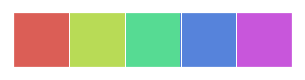

In [184]:
sns_colors = sns.color_palette("hls", kclusters)
pallete = sns.palplot(sns_colors)
pallete

In [185]:
def color_choro(cluster_label):
    return rgb_to_html(sns_colors[int(cluster_label)])

### The final cluster analysis map
(Which may be the second-ever Tel-Aviv Nightlife Intensity Map...)

In [208]:
map_tlv_clusters = folium.Map(location=telavivcoords, zoom_start=12)


folium.GeoJson(
    data = data_for_choro,
    style_function = lambda feature: {
        'fillColor': color_choro(feature['properties']['Labels']),
        'fillOpacity': 0.7,
        'color' : 'black',
        'weight' : 1,
    }    
).add_to(map_tlv_clusters)


folium.LayerControl().add_to(map_tlv_clusters)

map_tlv_clusters

In [222]:
final_data = clustering_data[['Labels', 'shemshchun']]
labels_neighborhoods = final_data.groupby('Labels').shemshchun.agg([('count', 'count'), ('shemshchun', ', '.join)])
labels_neighborhoods['color'] = ['red','yellow','green','blue','purple']
labels_neighborhoods

count                                         shemshchun   color
Labels                                                                  
0          10  'נאות אפקה ב, אוניברסיטת ת"א, יד אליהו, לבנה,י...     red
1           7  ביצרון ורמת ישראל, גני שרונה, הצפון החדש-החלק ...  yellow
2          16  'רמת אביב ג, אזור שדה דב, גבעת הרצל, אזור המלא...   green
3           1                             הצפון הישן-החלק הדרומי    blue
4          16  'נאות אפקה א, 'תכנית ל, אזור תעסוקה-צומת חולון...  purple

## Results and Discussion <a name="results"></a>

It is important to understand the limits of this analysis. Mainly, we don't know how reliable and statistically credible the Foursquare Data is. However, it perfectly matches my experience with Tel-Aviv and that is a good direction. Further research and comparison with other data sources should be pursued.

## Conclusion <a name="conclusion"></a>

We set out to discover and analyze the nightlife intensity in Tel-Aviv, by neighborhood. In conclusion, we found there is a great variety in the intensity of nightlife throughout the city. From the initial data exploration, with help from the choropleth map, is seems that the strongest nightlife intensity in Tel-Aviv is in the neighborhood 'לב העיר' (in the Yellow cateogry.) Later, the K-means Cluster Analysis singled out a different neighborhood, 'הצפון הישן-החלק הדרומי', colored in blue (in the central part of the city.)

From inspecting the most intense clusters (above), we can see that labels 1 and 3 were applied to the most intense neighborhoods in the city. It also appears that the unique neighborhood, given label 3, was singled out for having a very intense nightlife scene (like some others in the yellow category - label 1,) while also closing relatively early, mostly by around 22:00 PM. This may be a very interesting conclusion for our stakeholders. Perhaps people looking for a vibrant neighborhood to live in, but not one that will keep them up too late. University students for example.

This was interesting, thank-you very much!

In [230]:
clustering_data[clustering_data['Labels'].isin([3,1])].sort_values('Labels', ascending=False)

Labels                shemshchun   18   19   20   21   22   23   24
18       3    הצפון הישן-החלק הדרומי  0.0  0.0  3.0  3.0  5.0  1.0  0.0
8        1         ביצרון ורמת ישראל  0.0  2.0  0.0  1.0  1.0  3.0  0.0
12       1                 גני שרונה  0.0  0.0  0.0  4.0  2.0  2.0  1.0
15       1    הצפון החדש-החלק הדרומי  1.0  3.0  2.0  3.0  1.0  1.0  0.0
17       1  הצפון הישן - החלק הצפוני  0.0  2.0  1.0  2.0  3.0  3.0  2.0
23       1                לב תל-אביב  1.0  3.0  3.0  4.0  1.0  5.0  1.0
36       1                    עתידים  2.0  0.0  2.0  1.0  1.0  4.0  0.0
44       1                  צפון יפו  1.0  2.0  1.0  1.0  3.0  2.0  2.0